#### Pendings

Consideraciones:
- eliminar art_fundamentos del script inicial

In [ ]:
import os
import json
import pandas as pd

### **ÍNDICE**



1. Lectura de Sentencias
  
2. EDA
3. Limpieza de sentencias y preprocesamiento:
  - convertir a minúsculas
  - eliminación de puntuación
  - eliminar stop words
  - stemming/lemmatization?

5. Vectorización:
  - Bag of words
  - TF-IDF
  - Representaciones distribuidas:
    - Word embedding



# **PARTE 1: Predicción del Fallo**

## **1. Lectura de Sentencias**

In [ ]:
!unzip "./Files_prep.zip" -d "/content/sentences_json"

Archive:  ./Files_prep.zip
replace /content/sentences_json/Files_prep/22600.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
columnas = ['fecha_resolucion','sintesis_descriptiva','sintesis_analitica','antecedentes','fundamentos','fallo','art_fundamentos','resolucion']

judgments = pd.DataFrame(columns = columnas)

print(judgments)

Empty DataFrame
Columns: [fecha_resolucion, sintesis_descriptiva, sintesis_analitica, antecedentes, fundamentos, fallo, art_fundamentos, resolucion]
Index: []


In [ ]:
files = os.listdir("./sentences_json/Files_prep")

for file in files:
  with open("./sentences_json/Files_prep/"+file) as judgment_json:
    judgment = judgment_json.read()
    judgment = json.loads(judgment)
    judgments.loc[len(judgments.index)]=judgment['ANNO_RESOLUCION'], judgment['SINTESIS_DESCRIPTIVA'],judgment['SINTESIS_ANALITICA'],judgment['ANTECEDENTES'], judgment['FUNDAMENTOS'],judgment['FALLO_TXR:'], judgment['ART_FUNDAMENTOS'], judgment['ESTIMA']
    judgments = judgments.sort_index().reset_index(drop=True)



In [ ]:
judgments.head(5)

,fecha_resolucion,sintesis_descriptiva,sintesis_analitica,antecedentes,fundamentos,fallo,art_fundamentos,resolucion
0,2022,Interpuesto por el presidente del Gobierno en ...,Competencias sobre Seguridad Social; estructur...,Mediante escrito presentado en el registro de ...,El presidente del Gobierno de la Nación impugn...,"En atención a todo lo expuesto, el Tribunal Co...",[9.3],Desestima
1,2015,"Interpuesto por el Parlamento de Navarra, en r...",Derecho a la educación: constitucionalidad del...,"Mediante escrito de 12 de marzo de 2010, prese...",El objeto del presente recurso es analizar la ...,Desestimar el recurso de inconstitucionalidad ...,"[27, 19, 27.5]",Desestima
2,2018,Planteada por la Audiencia Provincial de Barce...,"Principio de proporcionalidad de las penas, co...",Por escrito registrado en este Tribunal Consti...,La Sección Novena de la Audiencia Provincial d...,Desestimar la presente cuestión de inconstituc...,"[149.1.6, 149.1.29]",Desestima
3,2011,Promovido por don José Luis Peña Domingo y don...,Vulneración del derecho a participar en los as...,Mediante escrito que tuvo entrada en el Regist...,El objeto del presente recurso de amparo consi...,Otorgar el amparo solicitado por don José Luis...,"[24.1, 23]",Estima
4,2023,Promovido por el Ayuntamiento de Granada respe...,Supuesta vulneración del derecho a la tutela j...,"El Ayuntamiento de Granada, representado por e...",El objeto del recurso\r\n\r\nEl objeto de este...,"En atención a todo lo expuesto, el Tribunal Co...","[24.1, 117.3]",Desestima


In [ ]:
#Imprimimos un ejemplo de antecedentes
print(judgments.iat[0,3])

Mediante escrito presentado en el registro de este tribunal el 3 de octubre de 2017, el abogado del Estado, en representación del presidente del Gobierno, interpuso recurso de inconstitucionalidad contra la Ley 21/2017, de 20 de septiembre, de la Agencia Catalana de Protección Social (en adelante, Ley 21/2017), publicada en el “Diari Oficial de la Generalitat de Catalunya” núm. 7460, de 22 de septiembre de 2017. El abogado del Estado invocó los arts. 161.2 CE y 30 de la Ley Orgánica del Tribunal Constitucional (LOTC), solicitando que se produjera la suspensión de la aplicación de la norma impugnada.

El recurso se fundamenta, en síntesis, en las siguientes alegaciones:

A) Se impugna la totalidad de la ley, basando su inconstitucionalidad in toto en la finalidad a la que se destina la norma, que es, a juicio del recurrente, crear una estructura de Estado que pueda ponerse al servicio de una eventual república independiente de Cataluña, propósito de ruptura con la Constitución que se pr

In [ ]:
#Imprimimos un ejemplo de fundamentos
print(judgments.iat[0,4])

El presidente del Gobierno de la Nación impugna la Ley del Parlamento de Cataluña 21/2017, de 20 de septiembre, de la Agencia Catalana de Protección Social. En la demanda, el abogado del Estado censura, en primer lugar, el conjunto de la Ley porque su finalidad es la creación de una estructura de Estado, vinculada con la “hoja de ruta” del proceso soberanista, adoleciendo de una serie de vicios de inconstitucionalidad que afectan a la totalidad de la Ley. Por otra parte, se dirige el recurso contra determinados preceptos, que incurrirían en una vulneración de las competencias estatales. En concreto, se trataría de los arts. 2.3; 3, apartados 1, párrafos c), d) y h), y 2; 5; y 14.3; disposición adicional primera; y disposiciones transitorias primera y tercera, que atentarían, principalmente, contra la competencia del Estado sobre legislación básica y régimen económico de la Seguridad Social del art. 149.1.17 CE.

Se han opuesto al recurso y han solicitado su desestimación el letrado del

In [ ]:
#Exportación de los datos para posibles futuros usos
judgments.to_csv("sentencias.csv", sep=',', index = False, encoding = "utf-8")


## **2. EDA**

#### **Obtención de artículos mencionados**


---


Función que permite obtener los artículos mencionados en las sentencias

In [ ]:
import re

def parse_articles (judgment):
  finded = []
  regex_art = r'\(art\.\s(\d+(?:\.\d+)*) CE\)'
  regex_art_np = r'art\.\s(\d+(?:\.\d+)*) CE'
  regex_articulo = r'artículo\s(\d+(?:\.\d+)*) CE'
  regex_articulo_nt = r'articulo\s(\d+(?:\.\d+)*) CE'

  regex_art_1 = r'\(art\.\s(\d+(?:\.\d+)*) Constitución Española\)'
  regex_art_np_1 = r'art\.\s(\d+(?:\.\d+)*) Constitución Española'
  regex_articulo_1 = r'artículo\s(\d+(?:\.\d+)*) Constitución Española'
  regex_articulo_nt_1 = r'articulo\s(\d+(?:\.\d+)*) Constitución Española'



  finded.append([str(x) for x in re.findall(regex_art, judgment, flags=re.IGNORECASE)])
  finded.append([str(x) for x in re.findall(regex_art_np, judgment, flags=re.IGNORECASE)])
  finded.append([str(x) for x in re.findall(regex_articulo, judgment, flags=re.IGNORECASE)])
  finded.append([str(x) for x in re.findall(regex_articulo_nt, judgment, flags=re.IGNORECASE)])

  finded.append([str(x) for x in re.findall(regex_art_1, judgment, flags=re.IGNORECASE)])
  finded.append([str(x) for x in re.findall(regex_art_np_1, judgment, flags=re.IGNORECASE)])
  finded.append([str(x) for x in re.findall(regex_articulo_1, judgment, flags=re.IGNORECASE)])
  finded.append([str(x) for x in re.findall(regex_articulo_nt_1, judgment, flags=re.IGNORECASE)])

  cleaned_arts = []
  for n in range(len(finded)):
    for j in range(len(finded[n])):
      if finded[n][j] not in cleaned_arts:
        cleaned_arts.append(finded[n][j])

  return cleaned_arts



In [ ]:
# Obtención de artículos utilizados en antecedentes

columnas = ['articulos_antecedentes']
bases_juridicas_antecedentes = pd.DataFrame(columns = columnas)
bases_juridicas_antecedentes['articulos_antecedentes'] = judgments['antecedentes'].apply(parse_articles)



In [ ]:
print(bases_juridicas_antecedentes.head(10))

                            articulos_antecedentes
0  [149.1.17, 149.1.16, 149.1, 149.1.1, 41, 161.2]
1                                      [27, 13, 1]
2                [149.1.6, 149.1.29, 17, 25, 25.1]
3                           [23, 23.1, 23.2, 24.1]
4                                           [24.1]
5                                   [14, 24.1, 24]
6                           [23, 23.1, 23.2, 24.1]
7                                 [24.1, 24.2, 24]
8     [149.1.8, 149.1.6, 149.1.1, 53.1, 34, 149.1]
9                                [24.1, 17.1, 123]


In [ ]:
# Obtención de artículos utilizados en fundamentos
columnas = ['articulos_fundamentos']
bases_juridicas_fundamentos = pd.DataFrame(columns = columnas)
bases_juridicas_fundamentos['articulos_fundamentos'] = judgments['fundamentos'].apply(parse_articles)



In [ ]:
print(bases_juridicas_fundamentos.head(10))

                               articulos_fundamentos
0  [9.3, 149.1.17, 148.1.20, 149.1.1, 41, 149.1.1...
1                   [27, 19, 27.5, 13.1, 27.1, 39.4]
2               [149.1.6, 149.1.29, 25, 117.3, 25.1]
3                                         [24.1, 23]
4                                      [24.1, 117.3]
5                            [24.1, 39.1, 14, 120.3]
6                                         [24.1, 23]
7                                       [24.1, 24.2]
8               [149.1.1, 149.1.8, 33, 34, 149.1.14]
9                         [24, 17.1, 24.1, 53.2, 17]


In [ ]:
judgments['articulos_antecedentes'] = bases_juridicas_antecedentes
judgments['articulos_fundamentos'] = bases_juridicas_fundamentos


In [ ]:
print(judgments.head(10))

   fecha_resolucion                               sintesis_descriptiva  \
0              2022  Interpuesto por el presidente del Gobierno en ...   
1              2015  Interpuesto por el Parlamento de Navarra, en r...   
2              2018  Planteada por la Audiencia Provincial de Barce...   
3              2011  Promovido por don José Luis Peña Domingo y don...   
4              2023  Promovido por el Ayuntamiento de Granada respe...   
5              2021  Promovido por doña Carmen Borrero Rodríguez en...   
6              2011  Promovido por don José Luis Peña Domingo y don...   
7              2020  Promovido por Euroinversiones Inmobiliarias Co...   
8              2013  Interpuesto por el Presidente de Gobierno en r...   
9              2010  Promovido por don Juan Luis Castro Moreno y do...   

                                  sintesis_analitica  \
0  Competencias sobre Seguridad Social; estructur...   
1  Derecho a la educación: constitucionalidad del...   
2  Principio de p

In [ ]:
print(judgments.columns)

Index(['fecha_resolucion', 'sintesis_descriptiva', 'sintesis_analitica',
       'antecedentes', 'fundamentos', 'fallo', 'art_fundamentos', 'resolucion',
       'articulos_antecedentes', 'articulos_fundamentos'],
      dtype='object')


#### **Estudio de correlaciones**


---



In [ ]:
# Matriz de correlación entre el fallo (estima/desestima y artículos citados)
# TO DO: tipificar todos los artículo a un número, estima/desestima binario y sacar de ahí la matriz corr.
corr_fallo_arts = judgments[['art_fundamentos', 'resolucion']].corr()

print(corr_fallo_arts)

Empty DataFrame
Columns: []
Index: []


<ipython-input-21-bb3c16862f7e>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_fallo_arts = judgments[['art_fundamentos', 'resolucion']].corr()


In [ ]:
import pandas as pd
from ast import literal_eval
from scipy.stats import chi2_contingency


# Selecciona las columnas relevantes
judgements_subset = judgments[['art_fundamentos', 'resolucion']]

# Convierte las listas -> strings
judgements_subset.loc[:, 'art_fundamentos'] = judgements_subset['art_fundamentos'].astype(str)

# Convierte las strings a listas
judgements_subset.loc[:, 'art_fundamentos'] = judgements_subset['art_fundamentos'].apply(lambda x: literal_eval(x) if x != '[]' else [])

# Explota las listas y resetea el índice
judgements_subset_exploded = judgements_subset.explode('art_fundamentos').reset_index(drop=True)

# Tabla de contingencia
contingency_table = pd.crosstab(judgements_subset_exploded['art_fundamentos'], judgements_subset_exploded['resolucion'])


print("Contingency Table:")
print(contingency_table)

# coef. de contingencia
chi2, p, _, _ = chi2_contingency(contingency_table)

print("coef. contingency:", chi2)
print("Valor p:", p)


Contingency Table:
resolucion       Desestima  Estima
art_fundamentos                   
1                       12       8
1.1                     50      42
1.2                      4       8
1.3                      3       4
10                       8       6
...                    ...     ...
96.1                     2       2
97                       8       4
99                       1       1
99.3                     0       1
99.5                     2       0

[328 rows x 2 columns]
coef. contingency: 838.3568735595799
Valor p: 1.2862926759493626e-46


<ipython-input-22-0db3e98c50f5>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  judgements_subset.loc[:, 'art_fundamentos'] = judgements_subset['art_fundamentos'].astype(str)
<ipython-input-22-0db3e98c50f5>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  judgements_subset.loc[:, 'art_fundamentos'] = judgements_subset['art_fundamentos'].apply(lambda x: literal_eval(x) if x != '[]' else [])


#### **Artículos ordenados por número de sentencias en los que aparecen**



---



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# recuentos de cada art
conteo_articulos = judgements_subset_exploded['art_fundamentos'].value_counts()

# orden según el recuento
articulos_ordenados = conteo_articulos.sort_values(ascending=False).index

# creación de cada gráfica
for articulo in articulos_ordenados:
    subset_articulo = judgements_subset_exploded[judgements_subset_exploded['art_fundamentos'] == articulo]

    # Verifica si hay valores en el subconjunto antes de intentar crear la gráfica
    if not subset_articulo.empty:
        # Gráfica de barras
        plt.figure(figsize=(6, 4))
        sns.countplot(data=subset_articulo, x='art_fundamentos', hue='resolucion')
        plt.title(f'Estima vs. Desestima para Artículo {articulo}')
        plt.xlabel('Artículo')
        plt.ylabel('Count')
        plt.xticks(rotation=0, ha='right')
        plt.legend(title='Resolución', loc='upper right')
        plt.show()

Output hidden; open in https://colab.research.google.com to view.

#### **Contabilización estima/desestima**


---



In [ ]:
# Conteo de "Estima" y "Desestima" en la columna 'resolucion'
clasf_resolucion = judgments['resolucion'].value_counts()

print("Conteo de 'Estima' y 'Desestima' en la columna 'resolucion':")
print(clasf_resolucion)

Conteo de 'Estima' y 'Desestima' en la columna 'resolucion':
Estima       1552
Desestima    1217
Name: resolucion, dtype: int64


#### **Obtener leyes mayormente mencionadas**



---



In [ ]:
import pandas as pd
import re

# Suponiendo que 'judgments' es tu DataFrame
# judgments = pd.DataFrame(...)

def extract_arts(texto):
    # Definir el patrón de expresión regular para los formatos de artículos
    pattern = r'(art\.\s\d+(\.\d+)?\s[A-Z]+|artículo\s\d+(\.\d+)?\s[A-Z]+)'
    regex = re.compile(pattern)

    articulos = []
    if isinstance(texto, str):
        for match in regex.finditer(texto):
            # Extraer el artículo encontrado
            articulo = match.group()
            print(articulo)  # Imprimir el artículo encontrado
            articulos.append(articulo)

    return ' '.join(articulos)

# Crear la nueva columna 'otros_articulos' e imprimir los artículos encontrados
judgments['otros_articulos'] = judgments['fundamentos'].apply(extract_arts)

Se han truncado las últimas 5000 líneas del flujo de salida.
art. 25.1 CE
art. 25.1 CE
art. 9.3 CE
art. 25.1 CE
art. 25.1 CE
art. 16 LIS
art. 16 LIS
art. 25.1 CE
art. 16 LIS
art. 16 LIS
art. 16 LIS
art. 16 LIS
art. 16 LIS
art. 16.10 LIS
art. 16 LIS
art. 16 LIS
art. 25.1 CE
art. 25.1 CE
art. 25.1 CE
art. 25.1 CE
art. 25.1 CE
art. 25.1 CE
art. 25.1 CE
art. 16 LIS
art. 16 LIS
art. 16 LIS
art. 16 LIS
art. 25.1 CE
art. 25.1 CE
art. 25.1 CE
art. 16 LIS
art. 16 LIS
art. 16 LIS
art. 16 LIS
art. 16 LIS
art. 25.1 CE
art. 16 LIS
art. 149.1 CE
art. 64 EAA
art. 149.1 CE
art. 4 LSF
art. 4.2 LSF
art. 11 LSF
art. 11 LSF
art. 30 LSF
art. 53 LSF
art. 94 CC
art. 156 CC
art. 94 CC
artículo 156 CC
art. 156 CC
art. 156 CC
art. 156 CC
art. 33 LOTC
art. 33.1 LOTC
artículo 156 CC
art. 156 CC
art. 33 LOTC
art. 94 CC
art. 39 CE
art. 117 CE
art. 9.3 CE
art. 94 CC
art. 24.2 CE
art. 156 CC
art. 117 CE
art. 39 CE
art. 39 CE
art. 9.3 CE
art. 94 CC
art. 117 CE
art. 39 CE
art. 39 CE
art. 39 CE
art. 39 CE
art. 39 CE
art

**Ranking de leyes**

In [ ]:
import pandas as pd
import re
from collections import Counter

# Suponiendo que 'judgments' es tu DataFrame y ya tiene la columna 'otros_articulos'
# judgments = pd.DataFrame(...)

def contar_acronimos(df, columna):
    # Compilar el patrón de expresión regular para extraer solo el acrónimo de la ley
    pattern = r'\b[A-Z]+\b'
    regex = re.compile(pattern)

    # Extraer y contar acrónimos en la columna especificada
    acronimos = []
    for texto in df[columna]:
        acronimos.extend(regex.findall(texto))

    # Contar la frecuencia de cada acrónimo
    contador = Counter(acronimos)

    # Ordenar los acrónimos por frecuencia y devolver como lista de tuplas
    ranking = contador.most_common()
    return ranking

# Llamar a la función y obtener el ranking de acrónimos
ranking_acronimos = contar_acronimos(judgments, 'otros_articulos')

# Imprimir el ranking
for ley, frecuencia in ranking_acronimos:
    print(f"{ley}: {frecuencia}")

CE: 29323
LEC: 2211
LOTC: 2200
CP: 1923
LOPJ: 1210
EAC: 887
LOREG: 710
CEDH: 608
LJCA: 541
LBRL: 421
LOFCA: 373
LOE: 313
LOU: 239
LET: 214
LGSS: 185
RPC: 178
LGT: 172
RCD: 157
CC: 151
EAA: 144
LSE: 129
LJS: 117
L: 107
LPC: 105
C: 101
LPL: 90
LHL: 85
LOPSC: 78
EAV: 73
LAJG: 68
LOHC: 66
EAPV: 61
LEEP: 60
LOGP: 58
LORAFNA: 57
RS: 55
TFUE: 54
LIS: 54
LGCA: 54
PIDCP: 52
TRLHL: 51
LORE: 47
EACL: 47
LOPP: 45
LOPD: 45
CDFUE: 42
LIRPF: 41
LC: 38
RPA: 38
RAM: 37
LGP: 32
LSV: 31
RCV: 31
TRLMV: 31
LRSV: 30
LDC: 30
EACM: 29
RP: 29
LEA: 28
LOFCS: 27
LPI: 26
TRLSRU: 24
LM: 23
R: 22
LH: 22
LA: 22
LAU: 21
LEP: 21
LPACAP: 20
TUE: 20
LOCM: 20
RPIB: 19
TRLEEP: 18
EAG: 16
LIVA: 16
LOTJ: 16
A: 15
LSSI: 15
LODE: 15
RGPD: 15
EARM: 14
B: 12
LCS: 12
T: 10
LOLR: 10
LRJSP: 9
LORCA: 8
EAE: 8
LGS: 8
LCEN: 8
LOEDE: 8
LOAES: 8
LORPM: 7
LISD: 7
LSH: 7
LOTT: 7
RARM: 7
RPV: 6
TCE: 6
ROTT: 6
LSF: 6
DD: 5
LODR: 5
LOCE: 5
LPHE: 5
D: 5
LITP: 5
LSC: 5
RH: 5
LJV: 5
LPA: 4
LMV: 4
E: 4
LCAP: 4
LORU: 4
ET: 3
LRBRL: 3
EAIB: 3
LRU

## **3. Limpieza de Datos**

In [ ]:
!pip install nltk
from nltk.corpus import stopwords
import nltk
import numpy as np
import sklearn
from string import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import re
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
judgments_copy = judgments.copy(deep=True)
judgments_subset = judgments_copy.loc[:,['antecedentes','resolucion']]
print(judgments_subset)

                                           antecedentes resolucion
0     Mediante escrito presentado en el registro de ...  Desestima
1     Mediante escrito de 12 de marzo de 2010, prese...  Desestima
2     Por escrito registrado en este Tribunal Consti...  Desestima
3     Mediante escrito que tuvo entrada en el Regist...     Estima
4     El Ayuntamiento de Granada, representado por e...  Desestima
...                                                 ...        ...
2764  Mediante escrito presentado en el registro gen...     Estima
2765  Mediante escrito presentado en el Registro Gen...  Desestima
2766  Mediante escrito registrado en este Tribunal e...  Desestima
2767  Mediante escrito presentado en el Registro Gen...     Estima
2768  Don José Benito Vieites Reboeiras, representad...     Estima

[2769 rows x 2 columns]


In [ ]:
with open("ejemploregexsentencia.txt", "w") as f:
  f.write(str(parse_articles(judgments.iat[0,3])))

In [ ]:
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer("spanish")
stemming = False
lemmatization = True
def preprocess_judgment(judgment, unified_articles = False):

    stopwords_sp = set(stopwords.words('spanish'))

    url_indicators = ['www',".es",".com"]

    processed_judgment = []

    judgment = word_tokenize(judgment)
    for token in judgment:

      token = token.lower()

      #Eliminación stop words, dígitos, puntuación(excepto el .)
      if token not in stopwords_sp and ((token not in punctuation) or (token=='.')):
        url_cond = False
        for indicator_url in url_indicators:
          if indicator_url in token:
            url_cond = True

        #Eliminación de tildes
        token = token.replace("á","a")
        token = token.replace("é","e")
        token = token.replace("í","i")
        token = token.replace("ó","o")
        token = token.replace("ú","u")
        token = token.replace("Ã©","e")
        token = token.replace("Ã¡","a")
        token = token.replace("Ã","i")
        token = token.replace("Ã³","o")
        token = token.replace("í³","o")
        token = token.replace("íº","u")
        token = token.replace("Ã±","ñ")
        token = token.replace("Ã¼","ü")
        token = token.replace("Ã¬","i")
        token = token.replace("Ã“","o")

        token = token.replace("í³","o")
        if not url_cond:
          if stemming and not lemmatization:
            token = stemmer.stem(token)
          if lemmatization and not stemming:
            token = lemmatizer.lemmatize(token)
          processed_judgment.append(token)

    #Consideración de un artículo con su número como un único token
    if unified_articles:
      i = 0
      for token in processed_judgment:
        if (token == 'art' or token=='articulo' or token=='artículo' or token=='articulos'):
          limit = 5
          words = 1
          condition = False
          #Para normalizar todos los artículos que se mencionan
          if processed_judgment[i+1] == '.':
            prov_word = "art"
          else:
            prov_word = "art."
          while((words<limit) and not condition):
            prov_word +=processed_judgment[i+words]
            if processed_judgment[i+words]=='ce' or processed_judgment[i+words]=='lopj' or processed_judgment[i+words]=='lecrim' or processed_judgment[i+words]=='lec':
              condition = True
              token = prov_word
            words+=1
          if condition:
            processed_judgment[i] = prov_word
            n = words
            while (n>0):
              processed_judgment.pop(i+n)
              n-=1

        i+=1

    return processed_judgment

In [ ]:
with open("ejemplosentencia.txt", "w") as f:
  f.write(str(preprocess_judgment(judgments.iat[0,3])))

In [ ]:
judgments_subset['antecedentes'] = judgments_subset['antecedentes'].apply(preprocess_judgment)

In [ ]:
judgments_subset.head(10)

,antecedentes,resolucion
0,"[mediante, escrito, presentado, registro, trib...",Desestima
1,"[mediante, escrito, 12, marzo, 2010, presentad...",Desestima
2,"[escrito, registrado, tribunal, constitucional...",Desestima
3,"[mediante, escrito, entrada, registro, general...",Estima
4,"[ayuntamiento, granada, representado, letrado,...",Desestima
5,"[mediante, escrito, entrada, registro, tribuna...",Estima
6,"[mediante, escrito, entrada, registro, general...",Estima
7,"[mediante, escrito, presentado, registro, gene...",Estima
8,"[mediante, escrito, presentado, registro, gene...",Estima
9,"[mediante, escrito, registrado, tribunal, 13, ...",Estima


In [ ]:
# Modificación de estima/desestime por un entero binario
judgments_subset['resolucion'] = judgments_subset['resolucion'].replace('Estima',1)
judgments_subset['resolucion'] = judgments_subset['resolucion'].replace('Desestima',0)


In [ ]:
judgments_subset.head(10)

,antecedentes,resolucion
0,"[mediante, escrito, presentado, registro, trib...",0
1,"[mediante, escrito, 12, marzo, 2010, presentad...",0
2,"[escrito, registrado, tribunal, constitucional...",0
3,"[mediante, escrito, entrada, registro, general...",1
4,"[ayuntamiento, granada, representado, letrado,...",0
5,"[mediante, escrito, entrada, registro, tribuna...",1
6,"[mediante, escrito, entrada, registro, general...",1
7,"[mediante, escrito, presentado, registro, gene...",1
8,"[mediante, escrito, presentado, registro, gene...",1
9,"[mediante, escrito, registrado, tribunal, 13, ...",1


In [ ]:
def unify_judgment(judgment):
  """Unifica el contenido de la review"""
  judgment_cleaned =''
  for x in judgment : judgment_cleaned = judgment_cleaned + ' ' + x
  return judgment_cleaned

In [ ]:
judgments_subset_unified = judgments_subset.copy(deep=True)
judgments_subset_unified['antecedentes']  = judgments_subset_unified['antecedentes'].apply(unify_judgment)


In [ ]:
judgments_subset_unified.head(10)


,antecedentes,resolucion
0,mediante escrito presentado registro tribunal...,0
1,mediante escrito 12 marzo 2010 presentado mis...,0
2,escrito registrado tribunal constitucional di...,0
3,mediante escrito entrada registro general tri...,1
4,ayuntamiento granada representado letrado ser...,0
5,mediante escrito entrada registro tribunal di...,1
6,mediante escrito entrada registro general tri...,1
7,mediante escrito presentado registro general ...,1
8,mediante escrito presentado registro general ...,1
9,mediante escrito registrado tribunal 13 marzo...,1


In [ ]:
judgments_subset_unified.to_csv("./judgments_cleaned_n.csv",sep=',', index = False, encoding = "utf-8")

### Exportación de datos



In [ ]:
judgments_copy_all = judgments.copy(deep=True)

judgments_copy_all['antecedentes'] = judgments_copy_all['antecedentes'].apply(preprocess_judgment)
judgments_copy_all['resolucion'] = judgments_copy_all['resolucion'].replace('Estima',1)
judgments_copy_all['resolucion'] = judgments_copy_all['resolucion'].replace('Desestima',0)
judgments_copy_all['antecedentes']  = judgments_copy_all['antecedentes'].apply(unify_judgment)
judgments_copy_all.to_csv("./judgments_copy_n.csv",sep=',', index = False, encoding = "utf-8")

## **4. Vectorización**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer

**División train_test**

In [ ]:
X_train,X_test, Y_train, Y_test = train_test_split(judgments_subset_unified['antecedentes'], judgments_subset_unified['resolucion'], random_state=16)
print("Train:",X_train.shape,Y_train.shape, "Test: ",(X_test.shape,Y_test.shape))


Train: (2076,) (2076,) Test:  ((693,), (693,))


In [ ]:
sentences = X_train.to_list()
for n in range(10):
  print(sentences[n],end="\n")


 26 septiembre 2016 entrada registro general tribunal oficio juzgado violencia mujer num . 1 tafalla acompañaba junto testimonio procedimiento filiacion num . 3-2016 auto 6 septiembre 2016 acuerda plantear cuestion inconstitucionalidad relacion ley 71 compilacion derecho civil foral navarra aprobada ley 1/1973 1 marzo redaccion dada ley foral 5/1987 1 abril posible vulneracion articulos 24.1 39.2 ce . antecedentes presente cuestion inconstitucionalidad siguientes 4 febrero 2016 presentada demanda determinacion legal filiacion menor consideraba padre dando lugar procedimiento filiacion num . 3-2016 tramitado juzgado violencia mujer num . 1 tafalla . tras celebracion vista asunto concluso resolucion organo judicial mediante providencia 27 junio 2016 puso manifiesto partes apartado b ley 71 compilacion derecho civil navarra prever posibilidad progenitor pueda reclamar filiacion matrimonial casos falta posesion podria ser compatible mandato impone articulo 39.2 ce hacer posible investigaci

#### **1. TF-IDF**

In [ ]:
tf_idf_vectorizer= TfidfVectorizer(token_pattern=None, tokenizer=preprocess_judgment)

# Adaptamos y transformamos el conjunto de entrenamiento
x_train_tfidf =tf_idf_vectorizer.fit_transform(X_train.to_list())

x_test_tfidf = tf_idf_vectorizer.transform(X_test.to_list())


In [ ]:
print(x_train_tfidf.toarray().shape)


(2076, 75050)


In [ ]:
# Imprimimos algunos tokens
bottom = 1000
limit = 3000
n = 0
for word in tf_idf_vectorizer.get_feature_names_out() :
  if bottom<n<limit:
    print(word,end="\n")
  n+=1

1/05
1/10
1/10/2009
1/1004
1/16/2015
1/1966
1/1970
1/1973
1/1979
1/198/2014
1/1980
1/1981
1/1982
1/1985
1/1986
1/1987
1/1989
1/1990
1/1991
1/1992
1/1993
1/1994
1/1995
1/1996
1/1997
1/1998
1/1999
1/2000
1/2001
1/2002
1/2003
1/2004
1/2004—
1/2005
1/2005—
1/2006
1/2007
1/2008
1/2009
1/2010
1/2011
1/2012
1/2013
1/2014
1/2015
1/2016
1/2017
1/2018
1/2018—
1/2020
1/2021
1/2022
1/24
1/26.422
1/3
1/3/93
1/30
1/32.011
1/39.211
1/419/2010
1/427/2019-g
1/47.375
1/58.147
1/623/2016
1/82
1/9/2013
1/94
1/dia
1/x
1/xi
10
10,14
10,30
10,5
10,5/6,5
10,6
10,99
10-
10-01-13
10-07-2018
10-09-12
10-1-2008
10-1-43
10-10-03
10-11
10-14
10-17
10-1992
10-2-2011
10-2004
10-2007.
10-2013
10-2014
10-2016
10-2017
10-2018
10-2018-j
10-2019
10-2019.
10-7-2009
10-9-2013
10-brel27902
10-brel28102
10.
10.000
10.000.000
10.01.2008
10.035
10.07.2017
10.1
10.1.
10.1.1
10.1.14
10.1.16
10.1.2
10.1.24
10.1.28
10.1.6
10.1.7
10.1.9
10.1.b
10.1.c
10.10
10.11
10.11.15
10.12
10.13
10.14
10.15
10.16
10.17
10.19.1
10.1c
10.2
10.2.1


In [ ]:
with open("features_name.txt","w") as f:
  for elem in tf_idf_vectorizer.get_feature_names_out():
    f.write(elem + "\n")


In [ ]:
x_train_tfidf.shape

(2076, 75050)

#### **2. Bag of words**

In [ ]:
count_vectorizer = CountVectorizer(token_pattern=None, tokenizer=preprocess_judgment)
x_train_count = count_vectorizer.fit_transform(X_train.to_list())
x_test_count = count_vectorizer.transform(X_test.to_list())


#### **3. Embeddings**

## **5. Modelos**


1. Naive Bayes
2. SVM
3. Logistic Reggresion
4. Decision Trees
5. Random Forest
6. Neural Network

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold, learning_curve
from sklearn.metrics import fbeta_score, make_scorer,roc_auc_score


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses

### **1.Comparación básica de modelos con TF-IDF**

In [ ]:
cv = 2

models = [
    GaussianNB(),
    LogisticRegression(random_state=16),
    RandomForestClassifier(random_state=16),
    LinearSVC(random_state=16),
    SGDClassifier(random_state=16),
]

model_res = []

for model in models:
    model_name = model.__class__.__name__

    pipeline = Pipeline(
      [
          ("model", model),
      ],
      verbose=True,
    )
    #Evaluamos cada modelo con parámetros por defecto 2 veces y calculamos la media
    scores_results = cross_val_score(pipeline, x_train_tfidf.toarray(), Y_train, scoring='accuracy', cv=cv)
    print((model_name, scores_results.mean(), scores_results.std() * 2 ))
    model_res.append((model_name, scores_results.mean(), scores_results.std() * 2 ))

metrics_tfidf = pd.DataFrame(model_res, columns=["model", "mean", "standard_dv"])

[Pipeline] ............. (step 1 of 1) Processing model, total=   2.1s
[Pipeline] ............. (step 1 of 1) Processing model, total=   1.3s
('GaussianNB', 0.7225433526011561, 0.026974951830443183)
[Pipeline] ............. (step 1 of 1) Processing model, total=   4.1s
[Pipeline] ............. (step 1 of 1) Processing model, total=   4.4s
('LogisticRegression', 0.7610789980732178, 0.011560693641618491)
[Pipeline] ............. (step 1 of 1) Processing model, total=   5.8s
[Pipeline] ............. (step 1 of 1) Processing model, total=   6.5s
('RandomForestClassifier', 0.7514450867052023, 0.046242774566473965)
[Pipeline] ............. (step 1 of 1) Processing model, total=   0.6s
[Pipeline] ............. (step 1 of 1) Processing model, total=   0.6s
('LinearSVC', 0.7846820809248555, 0.016377649325626242)
[Pipeline] ............. (step 1 of 1) Processing model, total=   3.2s
[Pipeline] ............. (step 1 of 1) Processing model, total=   3.2s
('SGDClassifier', 0.7904624277456647, 0.024

In [ ]:
print(metrics_tfidf)

                    model      mean  standard_dv
0              GaussianNB  0.722543     0.026975
1      LogisticRegression  0.761079     0.011561
2  RandomForestClassifier  0.751445     0.046243
3               LinearSVC  0.784682     0.016378
4           SGDClassifier  0.790462     0.024085


##### **Optimización de hiperparámetros de modelo seleccionado**

In [ ]:
sv = LinearSVC()


grid_params = {
    'C': [1, 10]
}

fold = StratifiedKFold( n_splits = 5, random_state = 16, shuffle=True )
grid_search = GridSearchCV(sv, param_grid = [grid_params], verbose = 1, cv = fold, n_jobs = 1, scoring = "accuracy")
grid_search.fit(x_train_tfidf, Y_train)
final_params = grid_search.best_params_
best_configuration = grid_search.best_estimator_

print(final_params)
print(best_configuration)
print(grid_search.best_score_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
{'C': 1}
LinearSVC(C=1)
0.8092469879518074


In [ ]:
results = grid_search.predict(x_test_tfidf)
# Imprimimos 20 predicciones de ejemplo

for n in range(20):
  print("Prediction: "+ str(results[n])+ " | Label: "+str(Y_test.iloc[n]) +" | Antecedente: "+X_test.iloc[n])


Prediction: 1 | Label: 1 | Antecedente:  escrito registrado tribunal dia 19 marzo 2013 don ramiro reynolds martinez procurador tribunales nombre representacion doña maria teresa kutz bandres interpuso recurso amparo resolucion judicial indica encabezamiento sentencia . hechos trae causa demanda amparo sintesis siguientes recurrente residente guipuzcoa presento autoliquidacion impuesto patrimonio correspondiente ejercicio 2008 instando continuacion rectificacion solicitud devolucion importe ingresado considerar puesto obligacion contribuir citado tributo sido suprimida resto incluidos territorios forales vizcaya alava normativa foral daba cobertura obligacion tributaria norma foral guipuzcoa 14/1991 devenido ilegal discriminar residentes territorio guipuzcoa obligandoles soportar obligacion tributaria inexistente resto territorio nacional obra ley 4/2008 23 diciembre . b fecha 10 febrero 2010 dicto acuerdo servicio gestion impuestos directos hacienda foral guipuzcoa rechazando rectifica

              precision    recall  f1-score   support

           0       0.80      0.74      0.77       302
           1       0.81      0.86      0.83       391

    accuracy                           0.80       693
   macro avg       0.80      0.80      0.80       693
weighted avg       0.80      0.80      0.80       693



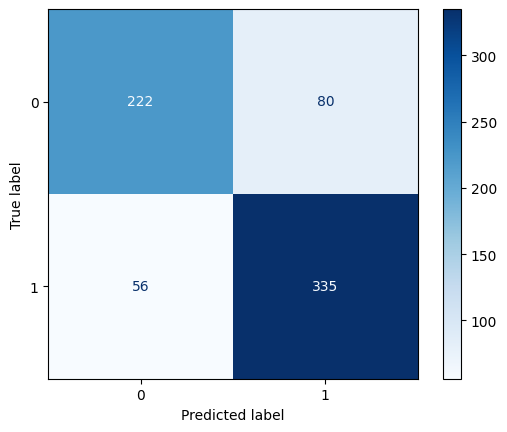

In [ ]:
from sklearn import metrics
report_best_tf_idf = metrics.classification_report(Y_test,results)
metrics.ConfusionMatrixDisplay.from_predictions(Y_test, results, cmap='Blues')
print(report_best_tf_idf)


In [ ]:
model = tf.keras.Sequential([
  layers.Input(shape=(75050,)),
  layers.Dense(2000),
  layers.Dense(750),
  layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2000)              150102000 
                                                                 
 dense_1 (Dense)             (None, 750)               1500750   
                                                                 
 dense_2 (Dense)             (None, 1)                 751       
                                                                 
Total params: 151603501 (578.32 MB)
Trainable params: 151603501 (578.32 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [ ]:
x_train_tfidf.toarray().shape

(2076, 75050)

In [ ]:
epochs = 3
history = model.fit(
    tf.reshape(tf.cast(x_train_tfidf.toarray(), tf.int32),[2076,75050]),
    #tf.cast(x_train_tfidf, tf.int32),
    tf.reshape(tf.cast(Y_train.values, tf.int32),[2076,1]),
    epochs=epochs)



Epoch 1/3
 3/65 [>.............................] - ETA: 2:51 - loss: 0.6926 - binary_accuracy: 0.4896

KeyboardInterrupt: ignored

In [ ]:
loss, accuracy = model.evaluate(   tf.reshape(tf.cast(x_test_tfidf.toarray(), tf.int32),[693,75050]), tf.reshape(tf.cast(Y_test.values, tf.int32),[693,1]))

print("Loss: ", loss)
print("Accuracy: ", accuracy)

### **2. Comparación de modelos con Count**


In [ ]:
cv = 2

models_c = [
    GaussianNB(),
    LogisticRegression(random_state=16, max_iter=1500),
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=16),
    LinearSVC(),
    SGDClassifier()
]

model_res_count = []

for model in models_c:
    model_name = model.__class__.__name__

    pipeline = Pipeline(
      [
          ("model", model),
      ],
      verbose=True,
    )
    #Evaluamos cada modelo con parámetros por defecto 5 veces y calculamos la media
    scores_results = cross_val_score(pipeline, x_train_count.toarray(), Y_train, scoring='accuracy', cv=cv)

    print(scores_results)
    model_res_count.append((model_name, scores_results.mean(), scores_results.std() * 2 ))



In [ ]:
metrics_count = pd.DataFrame(model_res_count, columns=["model", "mean", "standard_dv"])
print(metrics_count)

##### **Optimización de hiperparámetros de modelo seleccionado**

In [ ]:
sv = LinearSVC()


grid_params = {
    'C': [1, 10]
}

fold = StratifiedKFold( n_splits = 5, random_state = 16, shuffle=True )
grid_search = GridSearchCV(sv, param_grid = [grid_params], verbose = 1, cv = fold, n_jobs = 1, scoring = "accuracy")
grid_search.fit(x_train_count, Y_train)
final_params = grid_search.best_params_
best_configuration = grid_search.best_estimator_

print(final_params)
print(best_configuration)
print(grid_search.best_score_)

In [ ]:
results = grid_search.predict(x_test_count)
# Imprimimos 20 predicciones de ejemplo

for n in range(20):
  print("Prediction: "+ str(results[n])+ " | Label: "+str(Y_test.iloc[n]) +" | Antecedente: "+X_test.iloc[n])


In [ ]:
from sklearn import metrics
report_best_count = metrics.classification_report(Y_test,results)
metrics.ConfusionMatrixDisplay.from_predictions(Y_test, results, cmap='Blues')
print(report_best_count)

## **3. Red Neuronal con embedding**


In [ ]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses

In [ ]:
X_train_tf,X_test_tf, Y_train_tf, Y_test_tf = train_test_split(judgments_subset_unified['antecedentes'], judgments_subset_unified['resolucion'], random_state=16)
print("Train:",X_train_tf.shape,Y_train_tf.shape, "Test: ",(X_test_tf.shape,Y_test_tf.shape))

In [ ]:
train_ds = judgments_subset_unified.loc[0:2075,:]
test_ds =  judgments_subset_unified.loc[2076:,:]
train_ds.info()
test_ds.info()

In [ ]:
max_features = 100000
sequence_length = 250

In [ ]:
vectorized_layer = layers.TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [ ]:
vectorized_layer.adapt(X_train_tf)

In [ ]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorized_layer(text), label

In [ ]:
print(X_train_tf.iat[0])

In [ ]:
print("Vectorized sentence", vectorize_text(X_train_tf.iat[0], Y_train_tf.iat[0]))

In [ ]:
Y_train_tf.iat[0]

In [ ]:
training_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(X_train_tf.values, tf.string),
            tf.reshape(tf.cast(Y_train_tf.values, tf.int32),[2076,1])
        )
    )
)


In [ ]:
training_dataset

In [ ]:
test_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(X_test_tf.values, tf.string),
            tf.reshape(tf.cast(Y_test_tf.values, tf.int32),[693,1])
        )
    )
)
for features_tensor, target_tensor in training_dataset:

    print(f'features:{features_tensor} \n target:{target_tensor}')

In [ ]:
trainingv_dataset = training_dataset.map(lambda features_tensor, target_tensor: vectorize_text(features_tensor, target_tensor))


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

trainingv_dataset = trainingv_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
%load_ext tensorboard

In [ ]:
rm -rf ./logs/

In [ ]:
embedding_dim = 300
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dense(max_features/5),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

In [ ]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [ ]:
import datetime

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
epochs = 2
history = model.fit(
    trainingv_dataset,
    epochs=epochs,
    callbacks=[tensorboard_callback])

In [ ]:
%tensorboard --logdir logs/fit

In [ ]:
testv_dataset = test_dataset.map(lambda features_tensor, target_tensor: vectorize_text(features_tensor, target_tensor))
loss, accuracy = model.evaluate(testv_dataset)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

# **Parte 2: Sugerencias de artículos a aplicar en fundamentos**

 Objetivo: dado una sentencia obtener las m etiquetas (artículos) que pueden ser utilizados para los fundamentos dado el antecedente.


In [ ]:
#judgments = pd.read_csv("judgments_copy_n.csv")

In [ ]:
judgments.head(10)

,fecha_resolucion,sintesis_descriptiva,sintesis_analitica,antecedentes,fundamentos,fallo,art_fundamentos,resolucion,articulos_antecedentes,articulos_fundamentos,otros_articulos
0,2022,Interpuesto por el presidente del Gobierno en ...,Competencias sobre Seguridad Social; estructur...,Mediante escrito presentado en el registro de ...,El presidente del Gobierno de la Nación impugn...,"En atención a todo lo expuesto, el Tribunal Co...",[9.3],Desestima,"[149.1.17, 149.1.16, 149.1, 149.1.1, 41, 161.2]","[9.3, 149.1.17, 148.1.20, 149.1.1, 41, 149.1.1...",art. 150 EAC art. 150 EAC art. 150 EAC art. 15...
1,2015,"Interpuesto por el Parlamento de Navarra, en r...",Derecho a la educación: constitucionalidad del...,"Mediante escrito de 12 de marzo de 2010, prese...",El objeto del presente recurso es analizar la ...,Desestimar el recurso de inconstitucionalidad ...,"[27, 19, 27.5]",Desestima,"[27, 13, 1]","[27, 19, 27.5, 13.1, 27.1, 39.4]",art. 27 CE art. 27 CE art. 19 CE art. 19 CE ar...
2,2018,Planteada por la Audiencia Provincial de Barce...,"Principio de proporcionalidad de las penas, co...",Por escrito registrado en este Tribunal Consti...,La Sección Novena de la Audiencia Provincial d...,Desestimar la presente cuestión de inconstituc...,"[149.1.6, 149.1.29]",Desestima,"[149.1.6, 149.1.29, 17, 25, 25.1]","[149.1.6, 149.1.29, 25, 117.3, 25.1]",artículo 25 CE artículo 35.2 LOTC artículo 117...
3,2011,Promovido por don José Luis Peña Domingo y don...,Vulneración del derecho a participar en los as...,Mediante escrito que tuvo entrada en el Regist...,El objeto del presente recurso de amparo consi...,Otorgar el amparo solicitado por don José Luis...,"[24.1, 23]",Estima,"[23, 23.1, 23.2, 24.1]","[24.1, 23]",art. 23 CE art. 24.1 CE art. 23 CE art. 23 CE ...
4,2023,Promovido por el Ayuntamiento de Granada respe...,Supuesta vulneración del derecho a la tutela j...,"El Ayuntamiento de Granada, representado por e...",El objeto del recurso\r\n\r\nEl objeto de este...,"En atención a todo lo expuesto, el Tribunal Co...","[24.1, 117.3]",Desestima,[24.1],"[24.1, 117.3]",art. 24.1 CE art. 40.1 LOTC art. 50.1 LOTC art...
5,2021,Promovido por doña Carmen Borrero Rodríguez en...,Vulneración del derecho a la tutela judicial e...,Mediante escrito que tuvo entrada en el regist...,Pretensiones de las partes y objeto del recurs...,"En atención a todo lo expuesto, el Tribunal Co...","[24.1, 39.1]",Estima,"[14, 24.1, 24]","[24.1, 39.1, 14, 120.3]",art. 44 LOTC art. 24.1 CE art. 14 CE art. 44 L...
6,2011,Promovido por don José Luis Peña Domingo y don...,Vulneración del derecho a participar en los as...,Mediante escrito que tuvo entrada en el regist...,El objeto del presente recurso de amparo consi...,Otorgar el amparo solicitado por don José Luis...,"[24.1, 23]",Estima,"[23, 23.1, 23.2, 24.1]","[24.1, 23]",art. 23 CE art. 24.1 CE art. 23 CE art. 23 CE ...
7,2020,Promovido por Euroinversiones Inmobiliarias Co...,Vulneración del derecho a la tutela judicial e...,Mediante escrito presentado en el registro gen...,Único.- Aplicación de la doctrina sentada por ...,"En atención a todo lo expuesto, el Tribunal Co...","[24.1, 24.2]",Estima,"[24.1, 24.2, 24]","[24.1, 24.2]",art. 24.1 CE art. 24.2 CE art. 24.2 CE art. 24...
8,2013,Interpuesto por el Presidente de Gobierno en r...,Competencias sobre fundaciones y legislación c...,Mediante escrito presentado en el Registro Gen...,El presente recurso de inconstitucionalidad se...,Estimar el presente recurso de inconstituciona...,"[149.1.1, 149.1.8, 34, 33]",Estima,"[149.1.8, 149.1.6, 149.1.1, 53.1, 34, 149.1]","[149.1.1, 149.1.8, 33, 34, 149.1.14]",art. 34 CE art. 34 CE art. 34 CE art. 34 CE ar...
9,2010,Promovido por don Juan Luis Castro Moreno y do...,Vulneración del derecho a la tutela judicial e...,Mediante escrito registrado en este Tribunal e...,El presente recurso de amparo se dirige contra...,Estimar parcialmente el recurso de amparo inte...,"[17.1, 24, 24.1]",Estima,"[24.1, 17.1, 123]","[24, 17.1, 24.1, 53.2, 17]",art

In [ ]:
judgments.loc[0,'articulos_fundamentos']

['9.3', '149.1.17', '148.1.20', '149.1.1', '41', '149.1.16', '149.1']

In [ ]:
judgments_copy = judgments.copy(deep=True)
judgments_subset_fundamentos = judgments_copy.loc[:,['antecedentes','articulos_fundamentos']]
print(judgments_subset_fundamentos.head(10))


                                        antecedentes  \
0  Mediante escrito presentado en el registro de ...   
1  Mediante escrito de 12 de marzo de 2010, prese...   
2  Por escrito registrado en este Tribunal Consti...   
3  Mediante escrito que tuvo entrada en el Regist...   
4  El Ayuntamiento de Granada, representado por e...   
5  Mediante escrito que tuvo entrada en el regist...   
6  Mediante escrito que tuvo entrada en el regist...   
7  Mediante escrito presentado en el registro gen...   
8  Mediante escrito presentado en el Registro Gen...   
9  Mediante escrito registrado en este Tribunal e...   

                               articulos_fundamentos  
0  [9.3, 149.1.17, 148.1.20, 149.1.1, 41, 149.1.1...  
1                   [27, 19, 27.5, 13.1, 27.1, 39.4]  
2               [149.1.6, 149.1.29, 25, 117.3, 25.1]  
3                                         [24.1, 23]  
4                                      [24.1, 117.3]  
5                            [24.1, 39.1, 14, 120.3] 

In [ ]:
print(judgments_subset_fundamentos.head(10))

                                        antecedentes  \
0  Mediante escrito presentado en el registro de ...   
1  Mediante escrito de 12 de marzo de 2010, prese...   
2  Por escrito registrado en este Tribunal Consti...   
3  Mediante escrito que tuvo entrada en el Regist...   
4  El Ayuntamiento de Granada, representado por e...   
5  Mediante escrito que tuvo entrada en el regist...   
6  Mediante escrito que tuvo entrada en el regist...   
7  Mediante escrito presentado en el registro gen...   
8  Mediante escrito presentado en el Registro Gen...   
9  Mediante escrito registrado en este Tribunal e...   

                               articulos_fundamentos  
0  [9.3, 149.1.17, 148.1.20, 149.1.1, 41, 149.1.1...  
1                   [27, 19, 27.5, 13.1, 27.1, 39.4]  
2               [149.1.6, 149.1.29, 25, 117.3, 25.1]  
3                                         [24.1, 23]  
4                                      [24.1, 117.3]  
5                            [24.1, 39.1, 14, 120.3] 

In [ ]:
#Crear un array de 168 posiciones (correspondientes a los artículos)
import math
import ast
print([0,]*168)
def labels_to_array(labels, numeric = False):
  if numeric:
    label = [0,]*168

    for art in labels:
      print(art)
      art = str(art)
      splited = art.split(".")
      art = splited[0]
      #art_floor = math.floor(float(art))
      print(art)
      art = int(art)
      if art > 168:
        print(art)
      else:
        label[int(art)-1]=1

    all_labels = []
    for lab in label:
      all_labels.append(lab)
  else:
    label = []
    for art in labels:
        art = str(art)
        splited = art.split(".")
        art = splited[0]
        if float(art) < 169:
          if art not in label:
            label.append(str(art))

  return label



[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
print(labels_to_array([9.3, 24.1, 14, 53.1, 96, 125, 117.3, 10.2]))

In [ ]:
X_train,X_test, Y_train, Y_test = train_test_split(judgments_subset_fundamentos['antecedentes'], judgments_subset_fundamentos['articulos_fundamentos'], random_state=16)
print("Train:",X_train.shape,Y_train.shape, "Test: ",(X_test.shape,Y_test.shape))


Train: (2076,) (2076,) Test:  ((693,), (693,))


In [ ]:
articles = []
for n in range(1,170):
  articles.append(str(n))
print(articles)

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '

In [ ]:
y_test_all_labels = Y_test.apply(labels_to_array)

In [ ]:
y_train_all_labels = Y_train.apply(labels_to_array)

In [ ]:
y_train_all_labels,y_test_all_labels

(973           [24, 14, 39, 149]
 1340                       [24]
 711                    [81, 23]
 840         [149, 135, 134, 81]
 1240            [25, 14, 24, 9]
                  ...           
 635     [157, 142, 149, 9, 135]
 1345                       [24]
 581                       [149]
 2169         [23, 9, 1, 72, 71]
 2729                       [24]
 Name: articulos_fundamentos, Length: 2076, dtype: object,
 729            [24, 120]
 423             [14, 24]
 2295        [24, 53, 18]
 1457           [24, 117]
 678     [1, 86, 147, 20]
               ...       
 1806                [24]
 2723                [24]
 2515           [27, 149]
 576             [24, 23]
 244      [23, 9, 14, 72]
 Name: articulos_fundamentos, Length: 693, dtype: object)

In [ ]:
#only if y_transformation is numeric

y_train_all_label_n = Y_train.apply(labels_to_array,numeric=True)



counted = pd.DataFrame( columns = articles, index = [0])
counted.loc[0,:] = 0*169
print(counted)
for sentence in y_train_all_label_n:
  index = 1
  for art in sentence:

    if art == 1:
      counted.loc[0,str(index)]  =  counted.loc[0,str(index)] +  1
    index+=1



Se han truncado las últimas 5000 líneas del flujo de salida.
142
8.1
8
149.1.4
149
149.1.23
149
15
15
24.1
24
43
43
40.2
40
24
24
156.1
156
149.1.13
149
24.1
24
9.3
9
24
24
24.1
24
17.1
17
17
17
81.1
81
17.4
17
29.1
29
77.1
77
29
29
29.2
29
23
23
23.2
23
24.1
24
23
23
14
14
24.1
24
23.2
23
117
117
9
9
24.2
24
24.1
24
23
23
16.1
16
14
14
24
24
10.2
10
9.3
9
23.1
23
24.1
24
24.2
24
117.3
117
14
14
16
16
27
27
24.1
24
27.6
27
24.2
24
24.1
24
14
14
25
25
25.1
25
53.2
53
24.2
24
149.1.25
149
149.1.23
149
149.1
149
17.1
17
24.1
24
24.2
24
25.1
25
10.2
10
9.3
9
24.1
24
24.2
24
14
14
117.3
117
23
23
23.2
23
72
72
23.1
23
90.3
90
135
135
24.1
24
24.2
24
14
14
10.1
10
25.1
25
81.1
81
24.1
24
24
24
24.1
24
25
25
41
41
24.1
24
25.1
25
23.2
23
6
6
9.2
9
24.1
24
24.2
24
14
14
24.1
24
14
14
25.1
25
24.2
24
24.1
24
17.1
17
25.2
25
31.3
31
149.1.23
149
149.1.20
149
45.2
45
149.1.23
149
149.1.18
149
161.2
161
24.1
24
24.1
24
24.2
24
17.1
17
14
14
25.1
25
117
117
25.2
25
24.2
24
24.1
24
96
96
15
15
10.2


In [ ]:
counted.head(1)

,1,2,3,4,5,6,7,8,9,10,...,160,161,162,163,164,165,166,167,168,169
0,110,22,28,2,16,50,15,25,389,180,...,2,26,3,41,13,4,0,1,13,0


In [ ]:
counted.values

array([[110, 22, 28, 2, 16, 50, 15, 25, 389, 180, 9, 6, 13, 463, 66, 53,
        165, 121, 12, 67, 17, 21, 239, 1264, 230, 1, 53, 63, 4, 5, 75,
        13, 42, 1, 18, 14, 13, 30, 59, 12, 17, 3, 25, 1, 31, 7, 19, 3,
        15, 7, 7, 1, 133, 1, 4, 2, 1, 1, 0, 0, 0, 0, 0, 1, 2, 41, 3, 9,
        6, 1, 12, 21, 0, 2, 1, 3, 1, 2, 9, 0, 51, 1, 0, 0, 0, 77, 21, 5,
        2, 8, 0, 4, 14, 0, 0, 16, 12, 0, 5, 1, 3, 0, 49, 4, 1, 21, 0, 1,
        2, 2, 1, 1, 0, 0, 3, 4, 330, 13, 12, 45, 2, 18, 52, 7, 2, 1, 3,
        10, 1, 2, 5, 11, 18, 33, 36, 5, 26, 18, 20, 8, 6, 15, 9, 0, 0, 0,
        13, 32, 388, 9, 3, 9, 1, 0, 11, 47, 28, 6, 7, 2, 26, 3, 41, 13,
        4, 0, 1, 13, 0]], dtype=object)

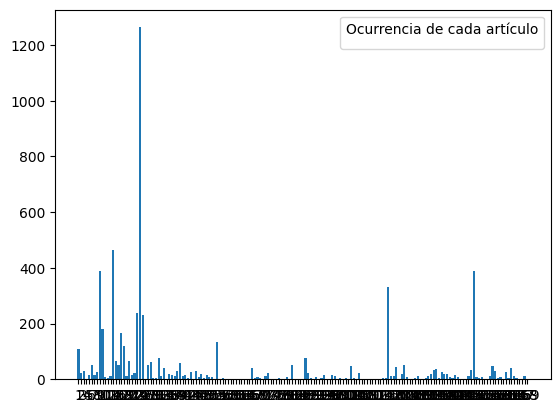

<Figure size 2000x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


fig, ax = plt.subplots()
ax.bar(counted.columns, counted.values[0])

ax.legend(title='Ocurrencia de cada artículo')
plt.figure().set_figwidth(20)
plt.show()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1 entries, 0 to 0
Columns: 169 entries, 1 to 169
dtypes: object(169)
memory usage: 1.4+ KB
[[110 22 28 2 16 50 15 25 389 180 9 6 13 463 66 53 165 121 12 67 17 21
  239 1264 230 1 53 63 4 5 75 13 42 1 18 14 13 30 59 12 17 3 25 1 31 7 19
  3 15 7 7 1 133 1 4 2 1 1 0 0 0 0 0 1 2 41 3 9 6 1 12 21 0 2 1 3 1 2 9 0
  51 1 0 0 0 77 21 5 2 8 0 4 14 0 0 16 12 0 5 1 3 0 49 4 1 21 0 1 2 2 1 1
  0 0 3 4 330 13 12 45 2 18 52 7 2 1 3 10 1 2 5 11 18 33 36 5 26 18 20 8
  6 15 9 0 0 0 13 32 388 9 3 9 1 0 11 47 28 6 7 2 26 3 41 13 4 0 1 13 0]]


<Axes: title={'center': 'Ocurrencia de artículos en fundamentos'}>

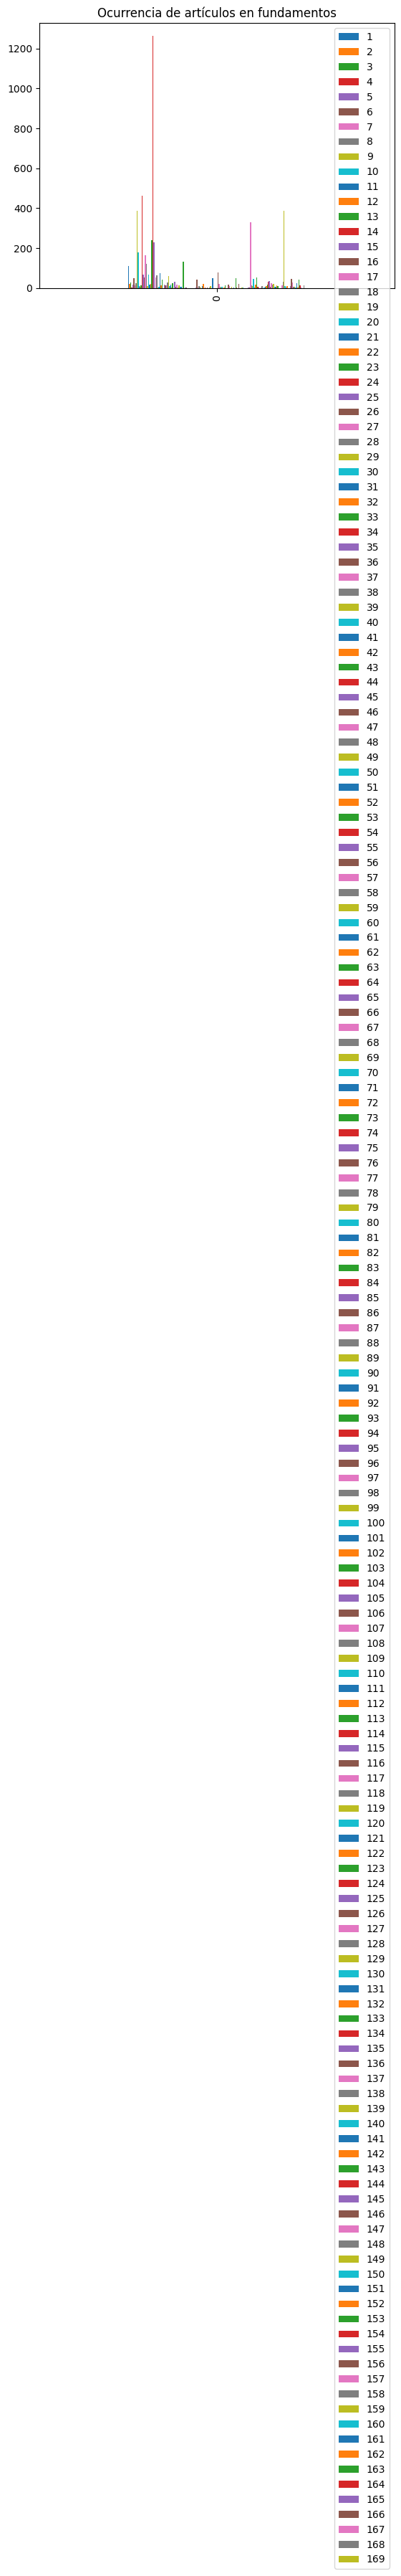

In [ ]:
counted.info()
print(counted.values)
import seaborn as sns
counted.plot(kind="bar",title="Ocurrencia de artículos en fundamentos")

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit([articles])

y_train_all_labels_mb = multilabel_binarizer.transform(y_train_all_labels)
y_test_all_labels_mb = multilabel_binarizer.transform(y_test_all_labels)



In [ ]:
"""vectorizer= TfidfVectorizer(token_pattern = None, tokenizer=preprocess_judgment)
x_train = vectorizer.fit_transform(X_train.to_list())
x_test = vectorizer.transform(X_test.to_list())"""

In [ ]:
x_train_array = x_train_tfidf.toarray()

In [ ]:
x_test_array = x_test_tfidf.toarray()

In [ ]:
x_train_array.shape, x_test_array.shape

((2076, 75050), (693, 75050))

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputClassifier


model = LinearRegression()


multi_model = MultiOutputClassifier(model)


multi_model.fit(x_train_array, y_train_all_labels_mb)


predictions = multi_model.predict(x_test_array)

AttributeError: ignored

In [ ]:
#print(multilabel_binarizer.classes_)


#print(predictions[20])

n=0
for result in predictions[20]:
  if result == 1:
    print(multilabel_binarizer.classes_[n])
  n+=1

print(Y_test.array[20])


In [ ]:
from sklearn.metrics import classification_report
report=classification_report(y_test_all_labels_mb, predictions)
report


In [ ]:
import pickle
filename = './class_arts_model.sav'
pickle.dump(model, open(filename, 'wb'))